In [1]:
class Tokenizer():
    
    def __init__(self):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        
    def fit(self, arr):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        for word in arr:
            if word not in self.word_index:
                self.index_word[self.vocab_size] = word
                self.word_index[word] = self.vocab_size
                self.vocab_size += 1
                    
    def transform(self, sentence):
        return [0] + [self.word_index[word] for word in sentence] + [1]
    
    def reverse_transform(self, encoded_sentence):
        return [self.index_word[num] for num in encoded_sentence[1:-1]]

In [2]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImgCapDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.image_transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_1 = os.path.join(self.img_dir, self.df.iloc[idx]["Image1"] + ".png")
        img_1 = Image.open(img_1)
        img_1 = self.image_transform(img_1)
        
        img_2 = os.path.join(self.img_dir, self.df.iloc[idx]["Image2"] + ".png")
        img_2 = Image.open(img_2)
        img_2 = self.image_transform(img_2)
        
        caption = torch.LongTensor(self.df.iloc[idx]["CaptionSeq"])

        return img_1, img_2, caption

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.models import densenet121

class CNN_Encoder(nn.Module):
    
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc = nn.Linear(256*256*16, 128)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc2 = nn.Linear(256*256*16, 128)

    def forward(self, x1, x2):
        x1 = F.relu(self.conv(x1))
        x1 = F.max_pool2d(x1, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)

        x2 = F.relu(self.conv2(x2))
        x2 = F.max_pool2d(x2, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc2(x2)

        return torch.cat((x1, x2), 1)
    
class VGG_Encoder(nn.Module):
    
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        self.vgg1 = vgg16(pretrained=True)
        seq1 = list(self.vgg1.classifier)
        seq1[-1] = nn.Linear(4096, 1024, bias=True)
        seq1.append(nn.ReLU(inplace=True))
        seq1.append(nn.Dropout(p=0.5, inplace=False))
        seq1.append(nn.Linear(1024, 128, bias=True))
        self.vgg1.classifier = nn.Sequential(*seq1)
        
        for param in self.vgg1.features.parameters():
            param.requires_grad = False
        
        self.vgg2 = vgg16(pretrained=True)
        seq2 = list(self.vgg2.classifier)
        seq2[-1] = nn.Linear(4096, 1024, bias=True)
        seq2.append(nn.ReLU(inplace=True))
        seq2.append(nn.Dropout(p=0.5, inplace=False))
        seq2.append(nn.Linear(1024, 128, bias=True))
        self.vgg2.classifier = nn.Sequential(*seq2)
        
        for param in self.vgg2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.vgg1(x1)
        x2 = self.vgg2(x2)
        
        return torch.cat((x1, x2), 1)
    
class DN_Encoder(nn.Module):
    
    def __init__(self):
        super(DN_Encoder, self).__init__()
        self.dn1 = densenet121(pretrained=True)
        self.dn1.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn1.features.parameters():
            param.requires_grad = False
        
        self.dn2 = densenet121(pretrained=True)
        self.dn2.classifier = nn.Linear(1024, 128, bias=True)
        
        for param in self.dn2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.dn1(x1)
        x2 = self.dn2(x2)
        
        return torch.cat((x1, x2), 1)
        

class RNN_Decoder(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTMCell(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, caption):

        cap = torch.transpose(self.embed(caption), 0, 1)
        output = torch.empty((caption.size(0), caption.size(1), self.vocab_size))

        for i in range(caption.size(1)):

            if i == 0:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                h = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                c = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                h, c = self.rnn(x, (h ,c))
            else:
                h, c = self.rnn(cap[i,:,:], (h, c))

            output[:,i,:] = self.fc(h)

        return output

In [4]:
!pip install biobert-embedding

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 748.9 MB 521 bytes/s          ��████████████████████▍         | 523.5 MB 4.8 MB/s eta 0:00:47 ��████████████████████▌         | 527.3 MB 4.8 MB/s eta 0:00:47 
     |████████████████████████████████| 123 kB 50.5 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for biobert-embedding: filename=biobert_embedding-0.1.2-py3-none-any.whl size=5701 sha256=7f6012dab153c2b48885d1c076675a4163d5846501d9a8996739b28c23d44fe9
  Stored in directory: /root/.cache/pip/wheels/67/26/c2/176e174845e1612a5d607eea1d1876e2c9aca2b5654a5cd681
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77046 sha256=cdc162c7e57367012499c4c553cdb0f4cb3b7cbcee394189cdb740bd8d83aa8d
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built biobert-embedding wrapt
  Attempting uninstall: six
    Found existing installation: s

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from biobert_embedding.embedding import BiobertEmbedding

class BaseModel():
    
    def __init__(self, df, image_address, sentence_length, vocab_size, epoch, encoder_name):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.df = df.sample(frac=1).reset_index(drop=True)
        train_df, test_df = self.train_val_split(self.df)
        train_df, val_df = self.train_val_split(train_df)
        
        train_ds = ImgCapDataset(train_df, image_address)
        val_ds = ImgCapDataset(val_df, image_address)
        test_ds = ImgCapDataset(test_df, image_address)
        
        self.train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
        self.val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
        self.test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
        
        self.EPOCH = epoch
        
        if encoder_name == "CNN":
            self.encoder = CNN_Encoder()
        elif encoder_name == "VGG":
            self.encoder = VGG_Encoder()
        elif encoder_name == "DenseNet":
            self.encoder = DN_Encoder()
        self.decoder = RNN_Decoder(256, sentence_length, vocab_size)
        
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        self.encoder_optim = torch.optim.Adam(self.encoder.parameters(), 0.0001)
        self.decoder_optim = torch.optim.Adam(self.decoder.parameters(), 0.0001)
        self.LOSS = torch.nn.CrossEntropyLoss()
        
    def train_val_split(self, df):
        split = 4*len(df)//5
        train = df.iloc[:split,:]
        val = df.iloc[split:,:]
        return train, val
    
    def train(self):
        self._training_loop(
            self.EPOCH, self.encoder, self.decoder, self.encoder_optim, 
            self.decoder_optim, self.LOSS, self.train_dl, self.val_dl
        )
        
    def _training_loop(self, epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_f, train_loader, val_loader):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for epoch in range(epochs):
            loss_train = 0.0
            for x1, x2, y in train_loader:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                
                out = encoder(x1, x2)
                out = decoder(out, y)
                out = out.to(device)
                loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                loss_train += loss.item()
            
            with torch.no_grad():
                loss_val = 0.0
                for x1, x2, y in val_loader:
                    x1 = x1.to(device)
                    x2 = x2.to(device)
                    y = y.to(device)

                    out = encoder(x1, x2)
                    out = decoder(out, y)
                    out = out.to(device)
                    loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))
                    loss_val += loss.item()
                print("Epoch", epoch, "Train Loss", loss_train/len(train_loader), "Validation Loss", loss_val/len(val_loader))
    
    def sample(self, tokenizer):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x1, x2, c = next(iter(self.test_dl))
        x1 = x1.to(device)
        x2 = x2.to(device)
        c = c.to(device)
        out1 = self.encoder.forward(x1, x2)
        out2 = self.decoder.forward(out1, c)
        encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

        decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            
        c = c.cpu().detach().numpy()
            
        real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x1[0].permute(1, 2, 0).cpu().detach().numpy())
        ax[1].imshow(x2[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print("Prediction:", decoded_out)
        print("Caption:", real)
        
    def evaluate(self, tokenizer):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dist = []
        for x1, x2, c in self.test_dl:
            x1 = x1.to(device)
            x2 = x2.to(device)
            c = c.to(device)
            out1 = self.encoder.forward(x1, x2)
            out2 = self.decoder.forward(out1, c)
            encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

            decoded_out = " ".join([tokenizer.index_word[x] for x in encoded_out[0] if x not in (0, 1)])
            c = c.cpu().detach().numpy()
            real = " ".join([tokenizer.index_word[x] for x in c[0] if x not in (0, 1)])

            biobert = BiobertEmbedding()
            preds = biobert.sentence_vector(decoded_out)
            caps = biobert.sentence_vector(real)
            dist.append(cosine(preds, caps))
            
        return np.mean(dist)
        
        

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score

In [7]:
df = pd.read_csv("../input/imagecaption/data/processed.csv")
df = df[["Image1", "Image2", "Clean_capt"]]
df.columns = ["Image1", "Image2", "Caption"]
print(df.shape)
df.head()

(4017, 3)


,Image1,Image2,Caption
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease


In [8]:
tokenizer = Tokenizer()
tokenizer.fit(reduce(lambda a, b: a+b, df.Caption.str.split()))
cap = df.Caption.apply(lambda x: tokenizer.transform(x.split()))
cap_len = cap.apply(len).value_counts().sort_index()
cap_len

3       10
4      109
5      469
6     1443
7      292
      ... 
65       1
66       1
86       1
89       1
90       2
Name: Caption, Length: 63, dtype: int64

In [9]:
LENGTH = 64
seq_trim = cap_len[cap_len.index > LENGTH]
print("If trimmed by length %d, %d captions will be trimmed" % (LENGTH, seq_trim.sum()))
print("If trimmed by length %d, %.2f%% of captions will be trimmed" % (LENGTH, seq_trim.sum()*100/len(df)))

If trimmed by length 64, 6 captions will be trimmed
If trimmed by length 64, 0.15% of captions will be trimmed


In [10]:
df["CaptionSeq"] = cap.apply(lambda x: x + [1] * (LENGTH - len(x)) if len(x) < LENGTH else x[:LENGTH])
df.head()

,Image1,Image2,Caption,CaptionSeq
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [11]:
cnn_model = BaseModel(df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "CNN")
cnn_model.train()

Epoch 0 Train Loss 4.431862897754456 Validation Loss 2.612657227167269
Epoch 1 Train Loss 1.8641564298120346 Validation Loss 1.4228691807607325
Epoch 2 Train Loss 1.1991004966060568 Validation Loss 1.0903127222526363
Epoch 3 Train Loss 0.9794314179731451 Validation Loss 0.938533076425878
Epoch 4 Train Loss 0.8444507159061313 Validation Loss 0.8152886011251589
Epoch 5 Train Loss 0.7399923253503645 Validation Loss 0.7402185114418588
Epoch 6 Train Loss 0.6578296961621468 Validation Loss 0.655608190632448
Epoch 7 Train Loss 0.5943958271549356 Validation Loss 0.5898040035148946
Epoch 8 Train Loss 0.5389901787412833 Validation Loss 0.5385270078734654
Epoch 9 Train Loss 0.4893837718767409 Validation Loss 0.4933881912289596
Epoch 10 Train Loss 0.44432872399595214 Validation Loss 0.45157029661463527
Epoch 11 Train Loss 0.41111080663174576 Validation Loss 0.42779263272518064
Epoch 12 Train Loss 0.3815504186179327 Validation Loss 0.3908136254403649
Epoch 13 Train Loss 0.35694902084814095 Validati

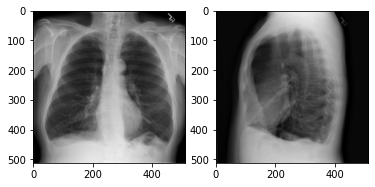

Prediction: no acute cardiopulmonary abnormality finding
Caption: no acute cardiopulmonary abnormality finding compatible emphysema



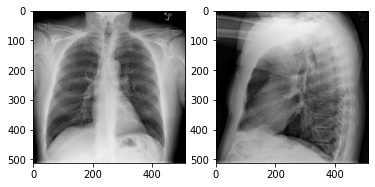

Prediction: no acute radiographic cardiopulmonary process
Caption: no acute radiographic cardiopulmonary process



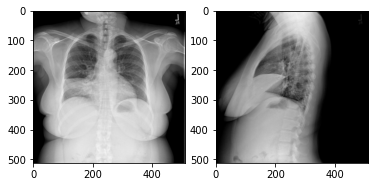

Prediction: stable right right lobe consolidation lobe pneumonia
Caption: stable right middle lobe consolidation consistent pneumonia



In [20]:
for _ in range(3):
    cnn_model.sample(tokenizer)
    print()

In [22]:
cnn_model.evaluate(tokenizer)

0.015378406861933267

In [23]:
vgg_model = BaseModel(df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "VGG")
vgg_model.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 0 Train Loss 4.5269447572483035 Validation Loss 2.6273274654295387
Epoch 1 Train Loss 1.8350718983952303 Validation Loss 1.276317587712916
Epoch 2 Train Loss 1.1161462564646087 Validation Loss 0.9529850773695039
Epoch 3 Train Loss 0.9036585899613658 Validation Loss 0.7861002247507979
Epoch 4 Train Loss 0.7745397492595341 Validation Loss 0.6901668077561913
Epoch 5 Train Loss 0.6813758715339329 Validation Loss 0.6018023897961873
Epoch 6 Train Loss 0.6093816299986395 Validation Loss 0.5510527753248448
Epoch 7 Train Loss 0.5515019725198331 Validation Loss 0.49491583028944525
Epoch 8 Train Loss 0.5020197466108369 Validation Loss 0.4546912926726225
Epoch 9 Train Loss 0.4588459050803451 Validation Loss 0.41271996688915463
Epoch 10 Train Loss 0.42297910871157735 Validation Loss 0.3851569647469172
Epoch 11 Train Loss 0.3919656406278196 Validation Loss 0.36080967325989793
Epoch 12 Train Loss 0.36334537950731954 Validation Loss 0.33335728089256983
Epoch 13 Train Loss 0.3400466523092726 Vali

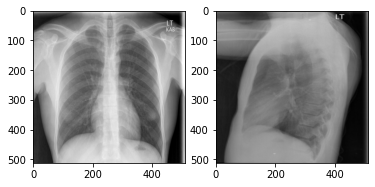

Prediction: no acute radiographic cardiopulmonary process
Caption: no acute radiographic cardiopulmonary process



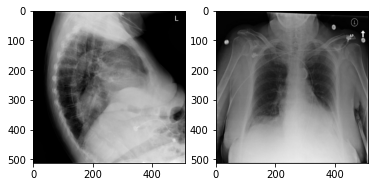

Prediction: heart size calcify aorta no active pulmonary edema pulmonary pneumonia x pulmonary lung
Caption: borderline heart size calcify aorta no active pulmonary edema lobar pneumonia probable large retrocardiac hiatal hernia



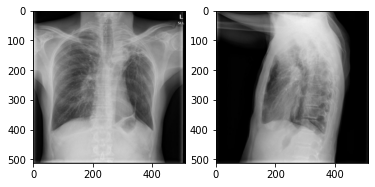

Prediction: stable left upper lobe left acute scar pleural finding previous active pulmonary pneumonia
Caption: stable left upper lobe collapse associate parenchymal scar pleural thicken finding consistent previous active pulmonary tuberculosis pneumonia



In [25]:
for _ in range(3):
    vgg_model.sample(tokenizer)
    print()

In [26]:
vgg_model.evaluate(tokenizer)

0.017646301083448456

In [37]:
dn_model = BaseModel(df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "DenseNet")
dn_model.train()

Epoch 0 Train Loss 4.614337097784007 Validation Loss 2.4996628121631903
Epoch 1 Train Loss 1.691756014127909 Validation Loss 1.2691576422714606
Epoch 2 Train Loss 1.1043332233932448 Validation Loss 1.0049486363806375
Epoch 3 Train Loss 0.9127806447307516 Validation Loss 0.8821735876362499
Epoch 4 Train Loss 0.7868658304214478 Validation Loss 0.75834896288267
Epoch 5 Train Loss 0.6914497325139016 Validation Loss 0.6811141949601289
Epoch 6 Train Loss 0.6179274489975864 Validation Loss 0.6295182835765001
Epoch 7 Train Loss 0.5594490709141915 Validation Loss 0.5637835831176944
Epoch 8 Train Loss 0.5107671777191369 Validation Loss 0.5116877515868443
Epoch 9 Train Loss 0.4681332119225715 Validation Loss 0.478952862140609
Epoch 10 Train Loss 0.43205110650069967 Validation Loss 0.4479003450492533
Epoch 11 Train Loss 0.4008010567530342 Validation Loss 0.42575492473637183
Epoch 12 Train Loss 0.37188842531686983 Validation Loss 0.3828782395618718
Epoch 13 Train Loss 0.3472202914934721 Validation 

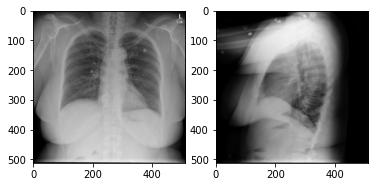

Prediction: no acute cardiopulmonary disease
Caption: no acute cardiopulmonary disease


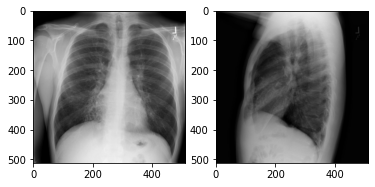

Prediction: no acute cardiopulmonary process stable right lobe xxxx
Caption: no acute cardiopulmonary process stable right middle lobe bronchiectasis xxxx postinfectious postinflammatory


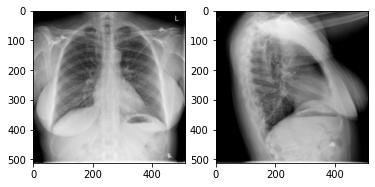

Prediction: no acute active pulmonary pleural disease
Caption: no acute active cardiac pulmonary pleural disease


In [39]:
for _ in range(3):
    dn_model.sample(tokenizer)

In [41]:
dn_model.evaluate(tokenizer)

0.0218209410781291